# Olympic Analysis Notebook
Aquí irá todo el código de A1, A2 y A3

### Librerías: 

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score


### A1: Leer Datasets

In [96]:
athletes = pd.read_csv('data/athlete_events.csv')
noc = pd.read_csv('data/noc_regions.csv')
results = pd.read_csv('data/results.csv', on_bad_lines='skip')

### A2: Análisis

##### Evolución del número de deportes por año

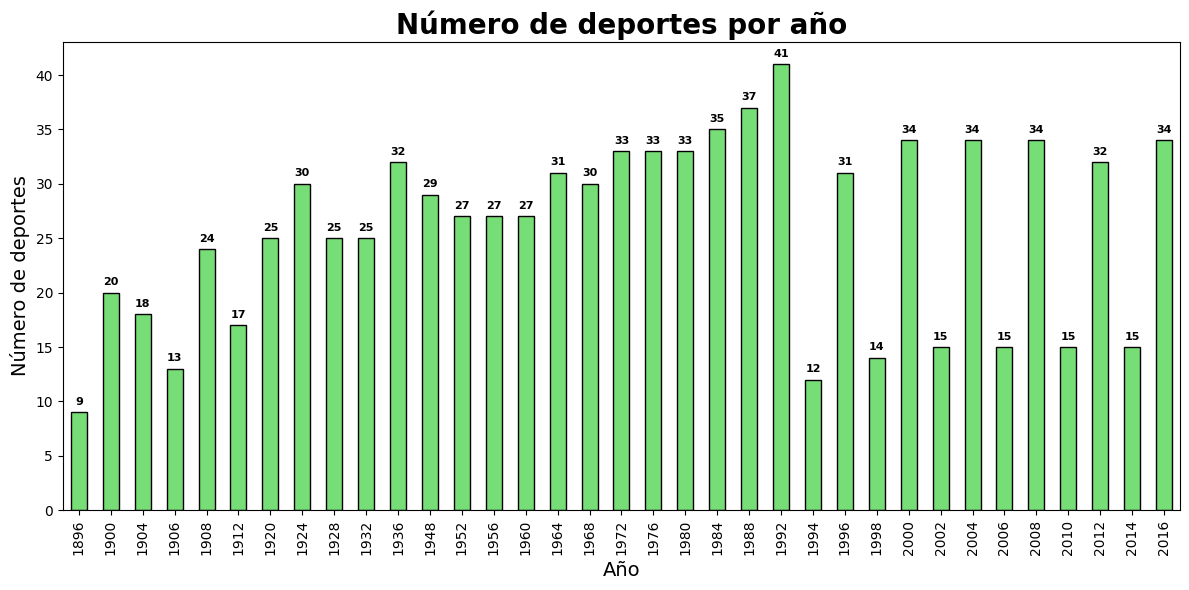

In [136]:
sports_per_year = athletes.drop_duplicates(['Year', 'Sport']) \
                           .groupby('Year')['Sport'].count()

plt.figure(figsize=(12,6))
sports_per_year.plot(kind='bar', color='#77DD77', edgecolor='black')
plt.title('Número de deportes por año', fontsize=20, fontweight='bold')
plt.xlabel('Año', fontsize=14)
plt.ylabel('Número de deportes', fontsize=14)
plt.xticks(rotation=90)
plt.tight_layout()

for i, value in enumerate(sports_per_year):
    plt.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=8, fontweight='bold')

    
plt.show()

##### Evolución de la participación femenina y masculina

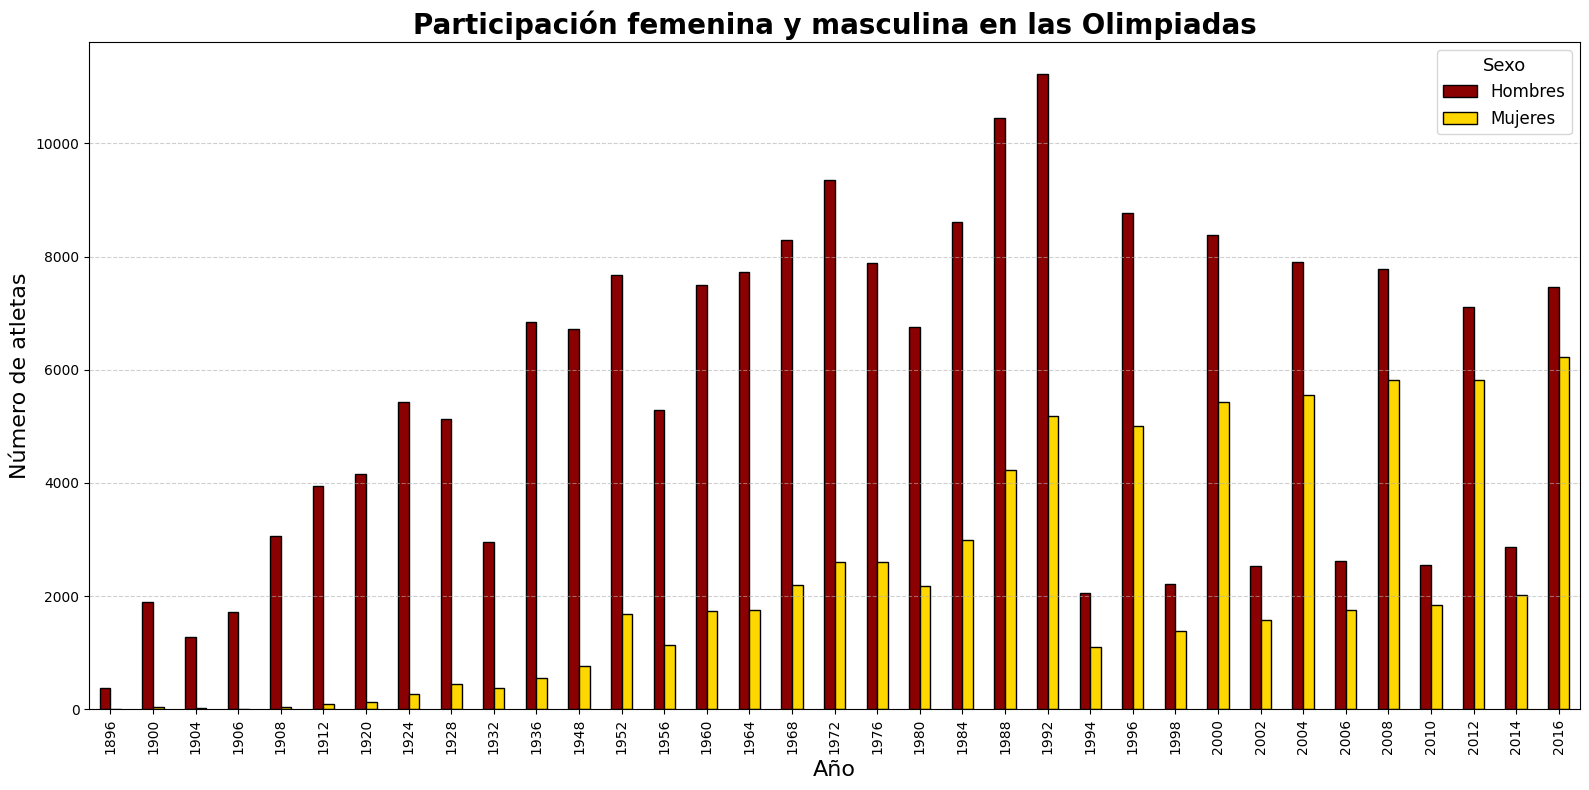

In [137]:
import matplotlib.pyplot as plt


sex_participation = athletes.groupby(['Year', 'Sex'])['ID'].count().unstack()
sex_participation = sex_participation[['M', 'F']]


plt.figure(figsize=(16,8))

sex_participation.plot(kind='bar', 
                       stacked=False, 
                       color=['#8B0000', '#FFD700'],
                       edgecolor='black',
                       linewidth=1,
                       ax=plt.gca())


plt.title('Participación femenina y masculina en las Olimpiadas', fontsize=20, fontweight='bold')
plt.xlabel('Año', fontsize=16)
plt.ylabel('Número de atletas', fontsize=16)
plt.xticks(rotation=90, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(['Hombres', 'Mujeres'], title='Sexo', title_fontsize=13, fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()


plt.show()

##### Top 50 países con más medallas

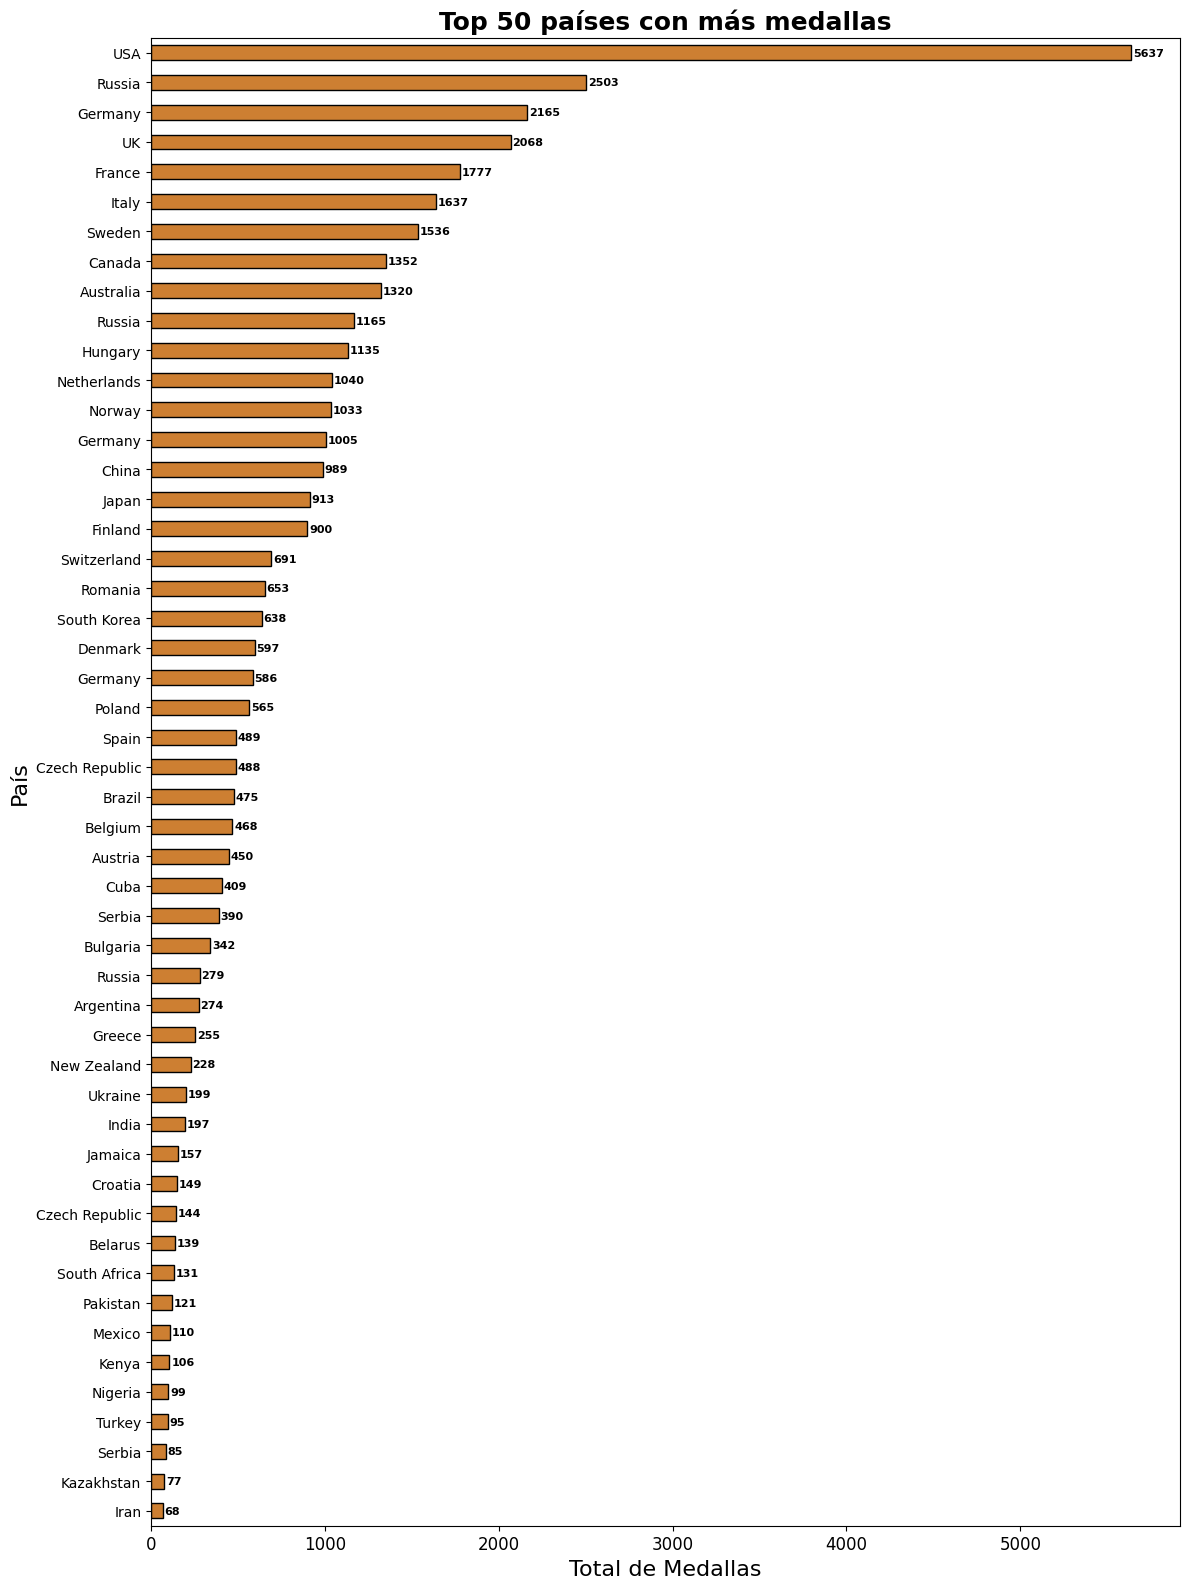

In [138]:
medals = athletes.dropna(subset=['Medal'])
medal_count = medals.groupby('NOC')['Medal'].count().sort_values(ascending=False).head(50)

medal_count = medal_count.reset_index().merge(noc, on='NOC')
medal_count = medal_count[['region', 'Medal']].set_index('region')


ax = medal_count.sort_values('Medal').plot(kind='barh', figsize=(12, 16), legend=False, color='#CD7F32', edgecolor='black')

ax.set_title('Top 50 países con más medallas', fontsize=18, fontweight='bold')
ax.set_xlabel('Total de Medallas', fontsize=16)
ax.set_ylabel('País', fontsize=16)
ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=10)

plt.tight_layout()

for i, value in enumerate(medal_count.sort_values('Medal')['Medal']):
    plt.text(value + 10,
             i,
             str(value), 
             ha='left', va='center', 
             fontsize=8, fontweight='bold')


plt.show()

### A3: Machine Learning

In [66]:
results = pd.read_csv('data/results.csv', on_bad_lines='skip')
athletes = pd.read_csv('data/athlete_events.csv')



results['Name'] = results['Name'].str.upper()
athletes['Name'] = athletes['Name'].str.upper()

def clean_name(name):
    if isinstance(name, str):
        name = re.sub(r'\(.*?\)', '', name)
        return name.strip()
    else:
        return name

results['Name'] = results['Name'].str.upper().apply(clean_name)
athletes['Name'] = athletes['Name'].str.upper().apply(clean_name)

In [67]:
#Correr una vez, mas de 1 sin reiniciar = Error

results = results.drop(columns=['Location'])
athletes = athletes.drop(columns=['Team', 'Games', 'Season', 'City', 'Sport'])

In [68]:
filtered_results = results[
    (results['Event'].isin(["100M Men", "100M Women"])) &
    (results['Medal'].isin(['G', 'S', 'B']))
]

filtered_athletes = athletes[
    (athletes['Event'].isin(["Athletics Men's 100 metres", "Athletics Women's 100 metres"])) &
    (athletes['Medal'].isin(["Gold", "Silver", "Bronze"]))
]


merged = pd.merge(
    filtered_results,
    filtered_athletes,
    left_on=['Name', 'Year'],
    right_on=['Name', 'Year'],
    how='inner'
)

merged_N_only = pd.merge(
    filtered_results,
    filtered_athletes,
    left_on=['Name'],
    right_on=['Name'],
    how='inner'
)

print('results.csv:        ', filtered_results.shape)
print('athlete_events.csv: ', filtered_athletes.shape)
print('Merge (N, Y):       ', merged.shape)
print('Merge (N):          ', merged_N_only.shape)

merged.head()

results.csv:         (142, 7)
athlete_events.csv:  (151, 10)
Merge (N, Y):        (28, 15)
Merge (N):           (41, 16)


,Gender,Event_x,Year,Medal_x,Name,Nationality,Result,ID,Sex,Age,Height,Weight,NOC,Event_y,Medal_y
0,M,100M Men,2016,B,ANDRE DE GRASSE,CAN,9.91,26135,M,21.0,176.0,70.0,CAN,Athletics Men's 100 metres,Bronze
1,M,100M Men,2008,S,RICHARD THOMPSON,TTO,9.89,119949,M,23.0,188.0,80.0,TTO,Athletics Men's 100 metres,Silver
2,M,100M Men,2008,B,WALTER DIX,USA,9.91,28811,M,22.0,175.0,80.0,USA,Athletics Men's 100 metres,Bronze
3,M,100M Men,2000,G,MAURICE GREENE,USA,9.87,42669,M,26.0,176.0,80.0,USA,Athletics Men's 100 metres,Gold
4,M,100M Men,1960,G,ARMIN HARY,EUA,10.2,46370,M,23.0,182.0,71.0,GER,Athletics Men's 100 metres,Gold


Existen 2 opciones de merge:

- Name & Year

- Name

Seleccioné `Name & Year` para evitar correr el riesgo de un merge poco fiable.

In [69]:
#Correr 1na vez, mas de 1 = Error

merged['Event'] = merged['Event_y']
merged['Medal'] = merged['Medal_y']
merged['NOC'] = merged['NOC']
merged['Sex'] = merged['Sex']

merged = merged.drop(columns=['Event_x', 'Event_y', 'Medal_x', 'Medal_y', 'Nationality', 'Gender'])
merged = merged[['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Event', 'Medal', 'Result']]

merged['Sex'] = merged['Sex'].map({'M': 0, 'F': 1})

X = merged[['Age', 'Sex', 'Height', 'Weight']]
y = merged['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)


print(f"{merged.head()} \n")
print(f"\nR² Score del modelo: {score:.2f}")

       ID              Name  Sex   Age  Height  Weight  NOC  Year  \
0   26135   ANDRE DE GRASSE    0  21.0   176.0    70.0  CAN  2016   
1  119949  RICHARD THOMPSON    0  23.0   188.0    80.0  TTO  2008   
2   28811        WALTER DIX    0  22.0   175.0    80.0  USA  2008   
3   42669    MAURICE GREENE    0  26.0   176.0    80.0  USA  2000   
4   46370        ARMIN HARY    0  23.0   182.0    71.0  GER  1960   

                        Event   Medal Result  
0  Athletics Men's 100 metres  Bronze   9.91  
1  Athletics Men's 100 metres  Silver   9.89  
2  Athletics Men's 100 metres  Bronze   9.91  
3  Athletics Men's 100 metres    Gold   9.87  
4  Athletics Men's 100 metres    Gold   10.2   


R² Score del modelo: 0.40


In [70]:
print("Introduce los datos del atleta para predecir el tiempo en 100m:")

edad = float(input("Edad: "))
sexo = int(input("Sexo (0 = Hombre, 1 = Mujer): "))
altura = float(input("Altura (cm): "))
peso = float(input("Peso (kg): "))

nuevo_atleta = pd.DataFrame([{
    'Age': edad,
    'Sex': sexo,
    'Height': altura,
    'Weight': peso
}])

tiempo_estimado = model.predict(nuevo_atleta)

print(f"""
Datos del atleta ingresados:
Edad: {edad} años
Sexo: {'Hombre' if sexo == 0 else 'Mujer'}
Altura: {altura} cm
Peso: {peso} kg
\nTiempo estimado en 100 metros: {tiempo_estimado[0]:.2f} segundos
""")

Introduce los datos del atleta para predecir el tiempo en 100m:

Datos del atleta ingresados:
Edad: 18.0 años
Sexo: Hombre
Altura: 188.0 cm
Peso: 72.0 kg

Tiempo estimado en 100 metros: 10.55 segundos



In [89]:
results = pd.read_csv('data/results.csv', on_bad_lines='skip')
athletes = pd.read_csv('data/athlete_events.csv')



results['Name'] = results['Name'].str.upper()
athletes['Name'] = athletes['Name'].str.upper()

def clean_name(name):
    if isinstance(name, str):
        name = re.sub(r'\(.*?\)', '', name)
        return name.strip()
    else:
        return name

results['Name'] = results['Name'].str.upper().apply(clean_name)
athletes['Name'] = athletes['Name'].str.upper().apply(clean_name)

results = results.drop(columns=['Location'])
athletes = athletes.drop(columns=['Team', 'Games', 'Season', 'City', 'Sport'])

filtered_results = results[
    (results['Event'].isin(["100M Men", "100M Women"])) &
    (results['Medal'].isin(['G', 'S', 'B']))
]

filtered_athletes = athletes[
    (athletes['Event'].isin(["Athletics Men's 100 metres", "Athletics Women's 100 metres"])) &
    (athletes['Medal'].isin(["Gold", "Silver", "Bronze"]))
]


merged = pd.merge(
    filtered_results,
    filtered_athletes,
    left_on=['Name', 'Year'],
    right_on=['Name', 'Year'],
    how='inner'
)

merged_N_only = pd.merge(
    filtered_results,
    filtered_athletes,
    left_on=['Name'],
    right_on=['Name'],
    how='inner'
)

merged['Event'] = merged['Event_y']
merged['Medal'] = merged['Medal_y']
merged['NOC'] = merged['NOC']
merged['Sex'] = merged['Sex']

merged = merged.drop(columns=['Event_x', 'Event_y', 'Medal_x', 'Medal_y', 'Nationality', 'Gender'])
merged = merged[['ID', 'Name', 'Sex', 'Age', 'Height', 'Weight', 'NOC', 'Year', 'Event', 'Medal', 'Result']]

merged['Sex'] = merged['Sex'].map({'M': 0, 'F': 1})

X = merged[['Age', 'Sex', 'Height', 'Weight']]
y = merged['Result']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
score = r2_score(y_test, y_pred)

print("Introduce los datos del atleta para predecir el tiempo en 100m:")

edad = float(input("Edad: "))
sexo = int(input("Sexo (0 = Hombre, 1 = Mujer): "))
altura = float(input("Altura (cm): "))
peso = float(input("Peso (kg): "))

nuevo_atleta = pd.DataFrame([{
    'Age': edad,
    'Sex': sexo,
    'Height': altura,
    'Weight': peso
}])

tiempo_estimado = model.predict(nuevo_atleta)

print(f"""
Datos del atleta ingresados:
Edad: {edad} años
Sexo: {'Hombre' if sexo == 0 else 'Mujer'}
Altura: {altura} cm
Peso: {peso} kg
\nTiempo estimado en 100 metros: {tiempo_estimado[0]:.2f} segundos
""")

Introduce los datos del atleta para predecir el tiempo en 100m:

Datos del atleta ingresados:
Edad: 17.0 años
Sexo: Mujer
Altura: 171.0 cm
Peso: 61.0 kg

Tiempo estimado en 100 metros: 11.32 segundos

